In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import glob, dill, sys, os

import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
from matplotlib import rc
rc('text', usetex=True)

import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import jax.random as random
from numpyro.infer import init_to_value

In [2]:
def model(x, y, xmin, xmax, xb_lower=3., xb_upper=30., xd_lower=1., xd_upper=100.):
    lnxmin, lnxmax = jnp.log(xmin), jnp.log(xmax)
    lnxmodel = numpyro.sample("lnxmodel", dist.Uniform(lnxmin, lnxmax), sample_shape=(len(x),))
    lnxsigma = numpyro.sample("lnxsigma", dist.HalfNormal(scale=0.1))
    numpyro.sample("obsx", dist.Normal(loc=lnxmodel, scale=lnxsigma), obs=jnp.log(x))
    xmodel = numpyro.deterministic("xmodel", jnp.exp(lnxmodel))
    xsigma = numpyro.deterministic("xsigma", jnp.exp(lnxsigma))

    power_short = numpyro.sample("power_short", dist.Normal(loc=0, scale=5))
    power_long = numpyro.sample("power_long", dist.Normal(loc=0, scale=5))
    lnp_break = numpyro.sample("lnp_break", dist.Uniform(jnp.log(xb_lower), jnp.log(xb_upper)))
    p_break = numpyro.deterministic("p_break", jnp.exp(lnp_break))
    R_break = numpyro.sample("R_break", dist.LogNormal(jnp.log(1e4), 1))

    def func(x, p_break, R_break):
        return jnp.where(x < p_break, R_break * (x/p_break)**power_short, R_break * (x/p_break)**power_long)

    rmodel = numpyro.deterministic("rmodel", func(xmodel, p_break, R_break))
    logrmodel = numpyro.deterministic("logrmodel", jnp.log(rmodel))
    logrsigma = numpyro.sample("logrsigma", dist.HalfNormal(scale=1.))
    numpyro.sample("obsy", dist.Normal(loc=logrmodel, scale=logrsigma), obs=jnp.log(y))

    xdense = numpyro.deterministic("xmodeldense", jnp.logspace(jnp.log(xd_lower), jnp.log(xd_upper), base=jnp.e))
    numpyro.deterministic("rmodeldense", func(xdense, p_break, R_break))

In [3]:
d = pd.read_csv("sample_clean.csv")

In [4]:
len(d)

4977

In [49]:
dt = 150
#dt = 200

In [50]:
tbins = np.arange(4000, 6500, dt)

In [68]:
np.sum(d.logg>4)

4968

In [51]:
logg_threshold = 4.
"""
def logg_teff_cut(teff):
    if teff>6200:
        return 4.1
    elif teff>5400:
        return 4.1 + 0.3*(6200.-teff)/800.
    else:
        return 4.4
logg_threshold = np.array([logg_teff_cut(_t0) for _t0 in d.teff])
resdir = 'plfit_results_t200g_p%d-%d/'%(pmin, pmax)
"""

"\ndef logg_teff_cut(teff):\n    if teff>6200:\n        return 4.1\n    elif teff>5400:\n        return 4.1 + 0.3*(6200.-teff)/800.\n    else:\n        return 4.4\nlogg_threshold = np.array([logg_teff_cut(_t0) for _t0 in d.teff])\nresdir = 'plfit_results_t200g_p%d-%d/'%(pmin, pmax)\n"

In [52]:
for i in range(len(tbins)-1):
    tl, tu = tbins[i], tbins[i+1]
    idx = (d.teff>tl) & (d.teff<tu) & (d.logg>logg_threshold)
    pobs = np.array(d[idx].Prot)
    print (tl, tu, np.percentile(pobs, [5, 10, 50, 90, 95]))

4000 4150 [10.3922 12.4386 23.761  39.696  43.0758]
4150 4300 [11.8288 12.6654 24.729  37.2234 40.0704]
4300 4450 [10.594  11.9665 24.4655 39.6155 42.69  ]
4450 4600 [ 9.7415 11.6448 23.9705 36.13   39.4255]
4600 4750 [10.24125 11.2325  24.6135  36.5755  38.0495 ]
4750 4900 [ 8.2715  9.6345 21.698  34.1575 36.906 ]
4900 5050 [ 8.21695  9.3905  22.5985  32.1233  34.30365]
5050 5200 [ 7.65085  9.5017  23.0315  32.8349  35.06465]
5200 5350 [ 7.0075  8.0952 20.549  30.6942 32.5819]
5350 5500 [ 5.9175  7.5714 19.168  28.0618 29.5266]
5500 5650 [ 5.8566  7.3476 18.658  24.8798 26.189 ]
5650 5800 [ 4.334    6.0435  15.16    21.011   22.68275]
5800 5950 [ 3.354   4.8026 12.767  18.0342 19.6812]
5950 6100 [ 2.52105  4.3848  10.847   15.4933  20.06225]
6100 6250 [ 1.87675  2.7945   7.5405  12.623   16.266  ]
6250 6400 [ 1.4138  1.8466  4.907  14.6226 18.689 ]


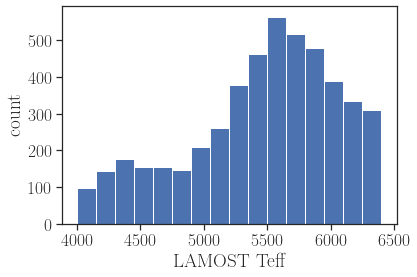

In [53]:
plt.xlabel("LAMOST Teff")
plt.ylabel("count")
plt.hist(d.teff, bins=tbins);

In [54]:
#pmin, pmax = 1., 100.
#pmin, pmax = 2., 50.
#pmin, pmax = 3., 30.

In [55]:
#resdir = 'plfit_results_p2-50/'
#resdir = 'plfit_results_p3-30/'
#resdir = 'plfit_results_t200_p%d-%d/'%(pmin, pmax)
#resdir = 'plfit_results_t%d_pct/'%dt

In [64]:
rnlabel = "variability amplitude $R_\mathrm{per}$\n normalized by Kepler photometric precision"
rlabel = "variability amplitude $R_\mathrm{per}$ (ppm)"
pnlabel = r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$"
dtlabel = 'empirical detection threshold'
tefflabel = 'LAMOST $T_\mathrm{eff}$ (K)'
protlabel = 'rotation period $P_\mathrm{rot}$ (days)'

## Fitting Rper vs Prot

In [ ]:
resdir = 'plfit_results_t%d_pct/'%dt

In [29]:
resume = True*0

plfit_results_t200_pct/teff4000-4200
9.91615 42.7492


sample: 100%|██████████| 2000/2000 [00:05<00:00, 360.28it/s, 63 steps of size 4.39e-02. acc. prob=0.90]


plfit_results_t200_pct/teff4200-4400
11.2901 42.003099999999996


sample: 100%|███████████| 2000/2000 [00:05<00:00, 374.70it/s, 7 steps of size 5.14e-02. acc. prob=0.78]


plfit_results_t200_pct/teff4400-4600
9.834 39.8572


sample: 100%|██████████| 2000/2000 [00:04<00:00, 405.95it/s, 31 steps of size 4.98e-02. acc. prob=0.87]


plfit_results_t200_pct/teff4600-4800
9.786150000000001 38.0034


sample: 100%|██████████| 2000/2000 [00:04<00:00, 417.17it/s, 15 steps of size 8.37e-02. acc. prob=0.87]


plfit_results_t200_pct/teff4800-5000
8.175 35.4952


sample: 100%|███████████| 2000/2000 [00:05<00:00, 349.84it/s, 7 steps of size 6.86e-02. acc. prob=0.63]


plfit_results_t200_pct/teff5000-5200
7.6419999999999995 34.7996


sample: 100%|███████████| 2000/2000 [00:05<00:00, 393.30it/s, 7 steps of size 8.44e-02. acc. prob=0.69]


plfit_results_t200_pct/teff5200-5400
7.15025 31.9095


sample: 100%|██████████| 2000/2000 [00:07<00:00, 256.98it/s, 15 steps of size 7.33e-02. acc. prob=0.69]


plfit_results_t200_pct/teff5400-5600
5.4784 28.290799999999997


sample: 100%|█████████| 2000/2000 [00:08<00:00, 222.28it/s, 127 steps of size 5.26e-02. acc. prob=0.94]


plfit_results_t200_pct/teff5600-5800
4.54315 24.300600000000003


sample: 100%|██████████| 2000/2000 [00:10<00:00, 195.37it/s, 63 steps of size 7.30e-02. acc. prob=0.96]


plfit_results_t200_pct/teff5800-6000
3.2918000000000003 19.876049999999996


sample: 100%|██████████| 2000/2000 [00:07<00:00, 281.60it/s, 31 steps of size 7.84e-02. acc. prob=0.79]


plfit_results_t200_pct/teff6000-6200
2.292 18.910999999999976


sample: 100%|█████████| 2000/2000 [00:10<00:00, 188.61it/s, 127 steps of size 5.96e-02. acc. prob=0.95]


plfit_results_t200_pct/teff6200-6400
1.4124 18.088399999999993


sample: 100%|█████████| 2000/2000 [00:06<00:00, 303.16it/s, 255 steps of size 4.93e-02. acc. prob=0.96]


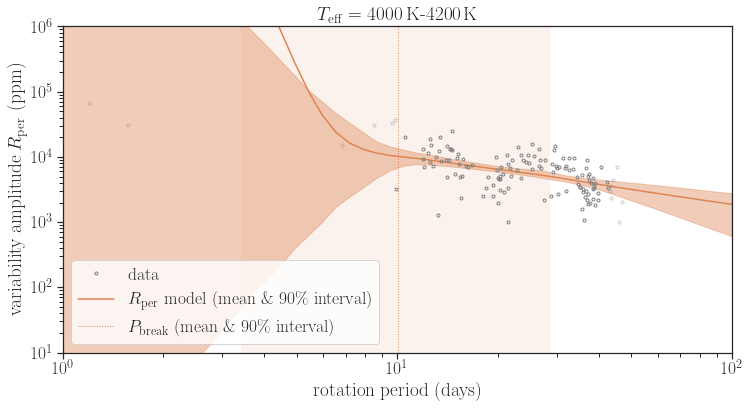

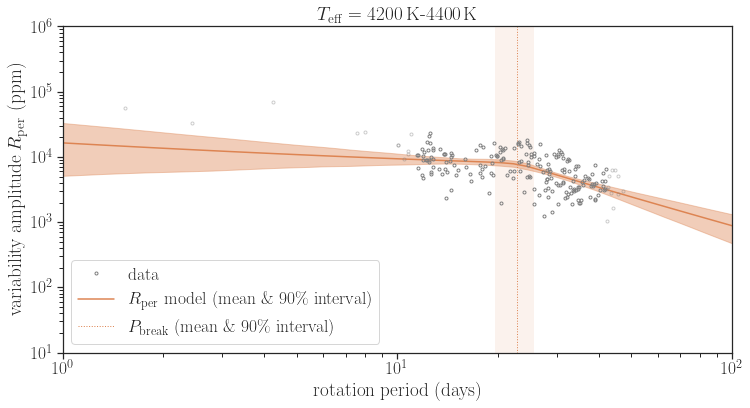

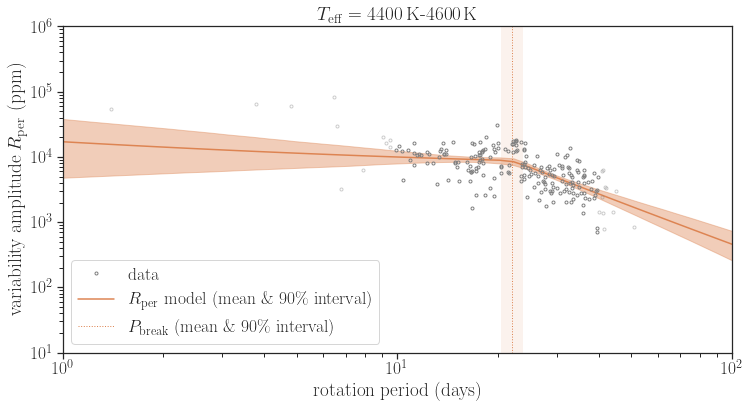

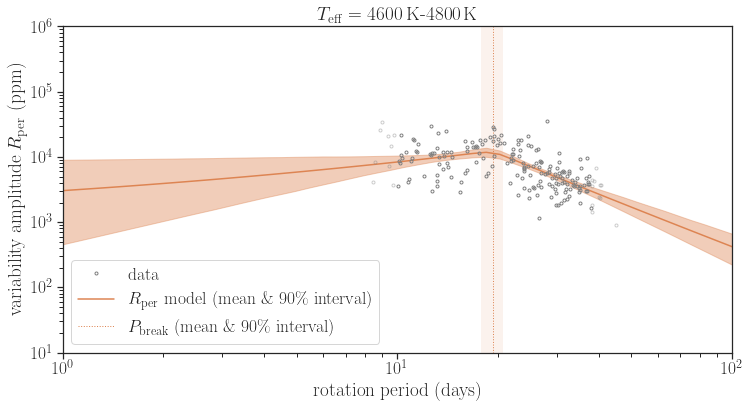

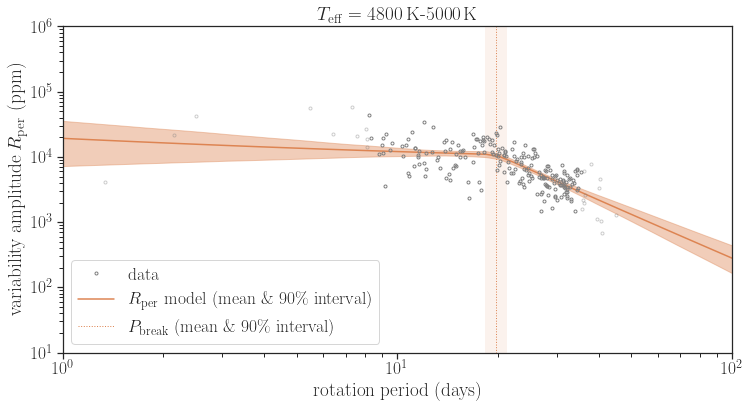

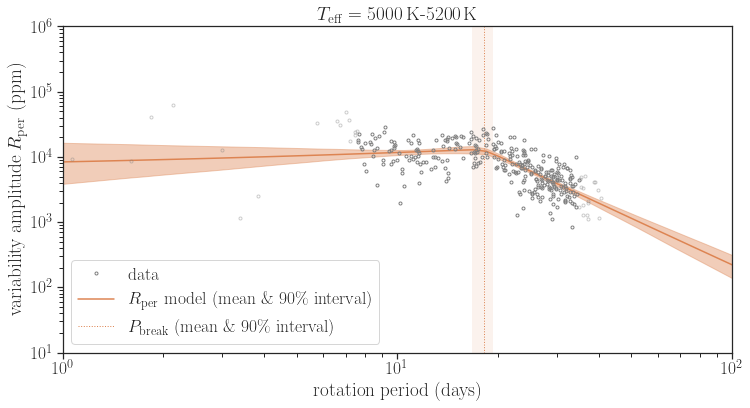

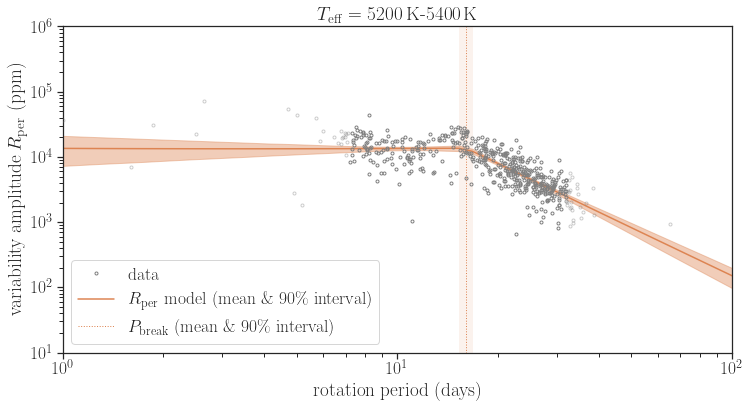

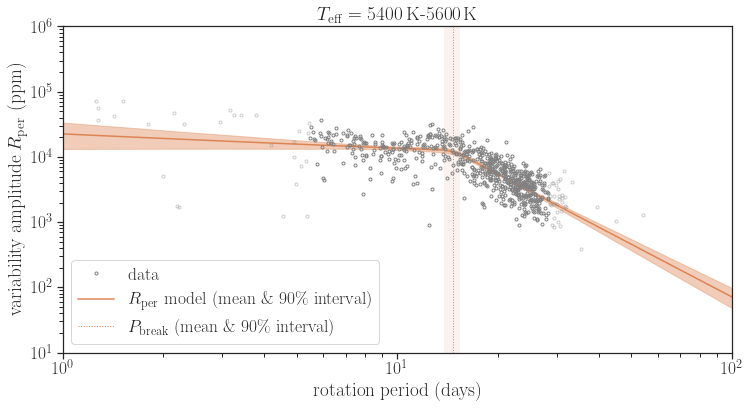

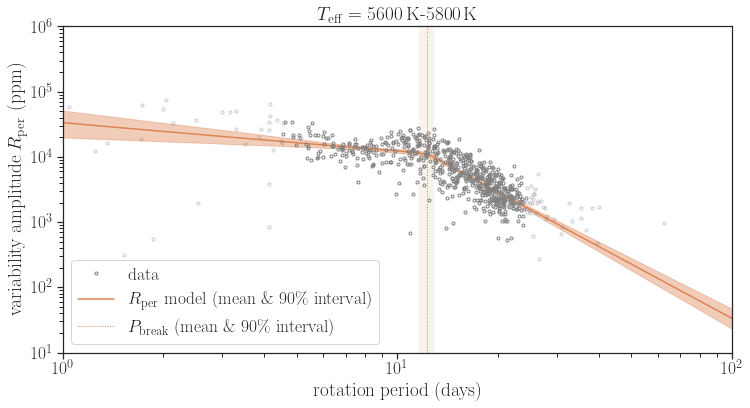

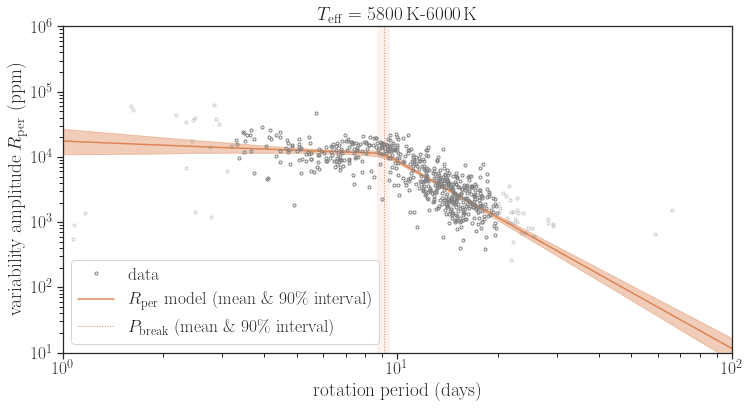

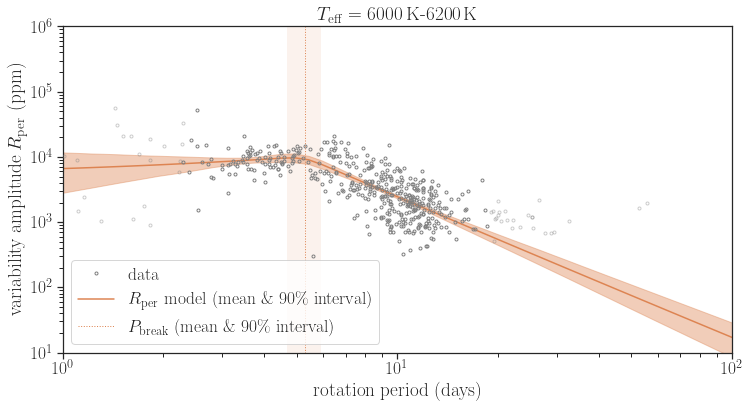

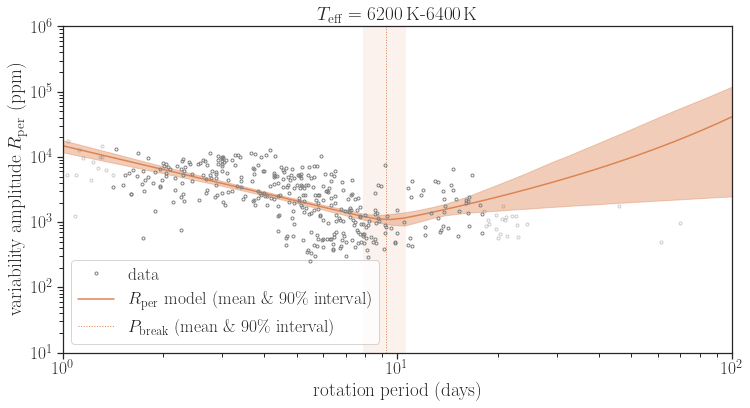

In [30]:
for i in range(len(tbins)-1):
#for i in range(7,8):
    tl, tu = tbins[i], tbins[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    

    idx = (d.teff>tl) & (d.teff<tu) & (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Prot, [5, 95])
    print (pmin, pmax)
    #pmin, pmax = 1., 100.
    
    idxp = (pmin<d.Prot) & (d.Prot<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Prot), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Prot, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))    
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 1000, 1000
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax, extra_fields=('potential_energy',))
        #mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.mean(samples['rmodeldense'], axis=0)
    r5, r95 = jnp.percentile(samples['rmodeldense'], q=jnp.array([5, 95]), axis=0)
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12,6))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(1, 100)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(protlabel)
    #idxd = (pobs>pmin) & (pobs<pmax)
    plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=1, zorder=1000, label='data')
    plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=1, zorder=1000, alpha=0.4)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    #plt.axvline(x=pbreak, label='$P_\mathrm{break}=%.1f\pm%.1f\,\mathrm{days}$'%(pbreak, pbreak_sd), 
    #            color='C1', ls='dotted', lw=1)
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$P_\mathrm{break}$ (mean \& 90\% interval)')
                #label='$P_\mathrm{break}=%.1f\pm%.1f\,\mathrm{days}$'%(pb, pbsd), )
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1,)
                      #label='90\% interval for $P_\mathrm{break}$')
    #plt.axvline(x=tau_cz(0.5*(tl+tu)), color='k', lw=0.5, ls='dotted', label='$Ro=1$')
    #plt.plot(pmod, rmean/rsigmamean, '--', color='C1')
    #plt.plot(pmod, rmean*rsigmamean, '--', color='C1')
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_model.png", dpi=200, bbox_inches="tight")

    #keys = ["R_break", "p_break", "power_long", "power_short", "logrsigma"]
    #labels = ['Rb', 'Pb', 'pl', 'ps', 'logrsigma']
    #hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
    #fig = corner.corner(hyper, labels=labels, show_titles="%.2f")
    #plt.savefig(outname+"_corner.png", dpi=200, bbox_inches="tight")

## Fitting Rper vs Ro

In [57]:
resdir = 'plfitro_results_t%d_pct/'%dt

In [58]:
tbins_all = np.array([4000, 6250])

In [65]:
resdir

'plfitro_results_t150_pct/'

plfitro_results_t150_pct/teff4000-6250
0.3278715297594667 1.6643812046887563


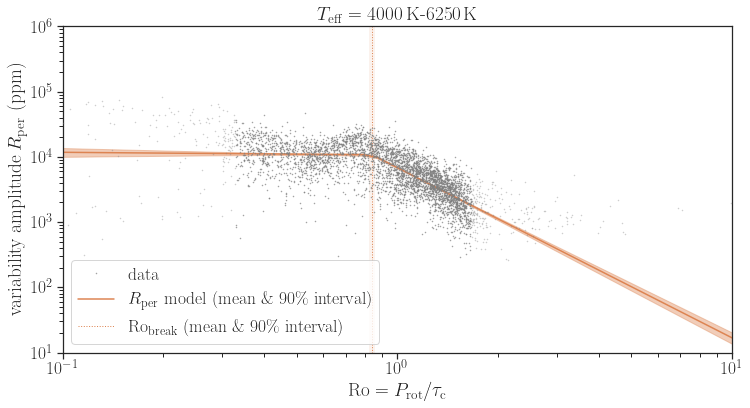

In [66]:
resume = True
#for i in range(len(tbins)-1):
    #tl, tu = tbins[i], tbins[i+1]
for i in range(len(tbins_all)-1):
    tl, tu = tbins_all[i], tbins_all[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    

    idx = (d.teff>tl) & (d.teff<tu) & (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Pnorm, [5, 95])
    print (pmin, pmax)
    
    idxp = (pmin<d.Pnorm) & (d.Pnorm<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Pnorm), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Pnorm, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))    
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 1000, 5000
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax, xb_lower=0.5, xb_upper=2., xd_lower=0.1, xd_upper=10, extra_fields=('potential_energy',))
        mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.mean(samples['rmodeldense'], axis=0)
    r5, r95 = jnp.percentile(samples['rmodeldense'], q=jnp.array([5, 95]), axis=0)
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12,6))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(0.1, 10)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(pnlabel)
    #idxd = (pobs>pmin) & (pobs<pmax)
    if tu-tl>1000:
        mew=0.5
        plt.plot(pobs, robs, '.', color='gray', markersize=1, zorder=1000, alpha=0.8, label='data')
        plt.plot(pobs_out, robs_out, '.', color='gray', markersize=1, zorder=1000, alpha=0.4)
    else:
        mew=1.
        plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=mew, zorder=1000, label='data')
        plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=mew, zorder=1000, alpha=0.7)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    #plt.axvline(x=pbreak, label='$P_\mathrm{break}=%.1f\pm%.1f\,\mathrm{days}$'%(pbreak, pbreak_sd), 
    #            color='C1', ls='dotted', lw=1)
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$\mathrm{Ro}_\mathrm{break}$ (mean \& 90\% interval)')
                #label='$P_\mathrm{break}=%.1f\pm%.1f\,\mathrm{days}$'%(pb, pbsd), )
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1,)
                      #label='90\% interval for $P_\mathrm{break}$')
    #plt.axvline(x=tau_cz(0.5*(tl+tu)), color='k', lw=0.5, ls='dotted', label='$Ro=1$')
    #plt.plot(pmod, rmean/rsigmamean, '--', color='C1')
    #plt.plot(pmod, rmean*rsigmamean, '--', color='C1')
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_model.png", dpi=200, bbox_inches="tight")

In [265]:
resdir

'plfitro_results_t150_pct/'

plfitro_results_t150_pct/pall_teff4000-6250
0.1 2.0


sample: 100%|█████████████| 600/600 [00:14<00:00, 40.46it/s, 63 steps of size 1.08e-01. acc. prob=0.92]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
       R_break  10412.41    287.52  10400.77   9906.88  10840.84    149.12      1.02
     lnp_break     -0.16      0.01     -0.16     -0.19     -0.14    197.24      1.01
   lnxmodel[0]      0.25      0.02      0.25      0.22      0.29    649.95      1.00
   lnxmodel[1]      0.40      0.03      0.40      0.35      0.43    827.24      1.00
   lnxmodel[2]      0.27      0.02      0.27      0.23      0.31    876.83      1.00
   lnxmodel[3]     -0.01      0.02     -0.01     -0.04      0.03    782.32      1.00
   lnxmodel[4]     -1.23      0.03     -1.23     -1.28     -1.19    853.78      1.00
   lnxmodel[5]      0.31      0.02      0.31      0.28      0.35    419.19      1.00
   lnxmodel[6]     -0.62      0.02     -0.62     -0.66     -0.58    519.57      1.00
   lnxmodel[7]     -0.12      0.02     -0.12     -0.16     -0.08    898.69      1.00
   lnxmodel[8]     -0.59      0.02     -0.59     -0.62     -0.55

lnxmodel[2199]     -1.21      0.02     -1.21     -1.25     -1.17    718.98      1.00
lnxmodel[2200]     -1.93      0.02     -1.92     -1.96     -1.88    331.12      1.00
lnxmodel[2201]      0.25      0.02      0.25      0.21      0.28    529.58      1.00
lnxmodel[2202]      0.05      0.02      0.05      0.01      0.09    597.23      1.00
lnxmodel[2203]      0.07      0.02      0.07      0.04      0.11    462.07      1.00
lnxmodel[2204]      0.36      0.02      0.36      0.32      0.39    788.66      1.00
lnxmodel[2205]     -0.13      0.02     -0.13     -0.17     -0.09   1026.96      1.00
lnxmodel[2206]     -2.14      0.02     -2.14     -2.17     -2.10    566.54      1.00
lnxmodel[2207]     -0.93      0.02     -0.93     -0.97     -0.90    694.22      1.00
lnxmodel[2208]     -0.10      0.02     -0.10     -0.14     -0.06    690.70      1.00
lnxmodel[2209]      0.22      0.02      0.22      0.18      0.26    670.73      1.00
lnxmodel[2210]     -0.67      0.02     -0.67     -0.70     -0.63 

lnxmodel[4198]      0.24      0.03      0.24      0.19      0.28    863.96      1.00
lnxmodel[4199]     -0.43      0.02     -0.43     -0.47     -0.40    696.54      1.00
lnxmodel[4200]     -0.26      0.02     -0.26     -0.30     -0.22    921.10      1.00
lnxmodel[4201]      0.42      0.02      0.42      0.38      0.46    679.60      1.00
lnxmodel[4202]      0.33      0.02      0.32      0.28      0.36    566.99      1.00
lnxmodel[4203]      0.62      0.02      0.62      0.58      0.66    421.49      1.00
lnxmodel[4204]      0.36      0.02      0.36      0.32      0.40    809.07      1.00
lnxmodel[4205]      0.43      0.02      0.43      0.40      0.47    682.42      1.00
lnxmodel[4206]     -0.34      0.02     -0.34     -0.38     -0.30    604.49      1.00
lnxmodel[4207]      0.06      0.02      0.06      0.02      0.10    512.52      1.00
lnxmodel[4208]     -0.12      0.02     -0.12     -0.16     -0.08    577.92      1.00
lnxmodel[4209]     -0.06      0.03     -0.06     -0.11     -0.03 

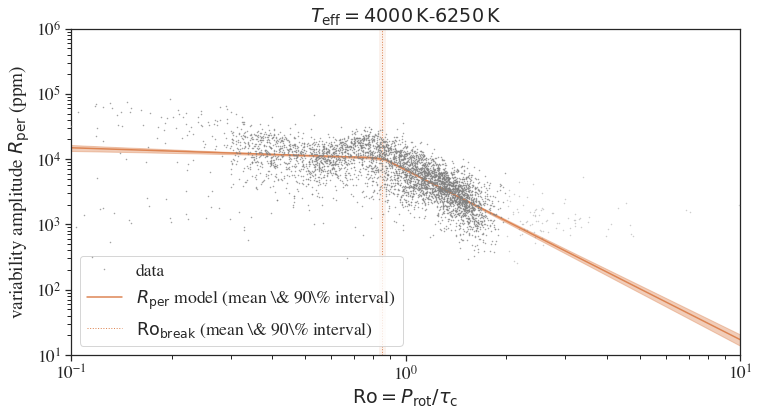

In [270]:
resume = True*0
for i in range(len(tbins_all)-1):
    tl, tu = tbins_all[i], tbins_all[i+1]
    outname = resdir+"pall_teff%d-%d"%(tl, tu)
    print (outname)    

    idx = (d.teff>tl) & (d.teff<tu) & (d.logg>logg_threshold)
    pmin, pmax = 0.1, 2.
    print (pmin, pmax)
    
    idxp = (pmin<d.Pnorm) & (d.Pnorm<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Pnorm), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Pnorm, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))    
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 100, 500
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax, xb_lower=0.5, xb_upper=2., xd_lower=0.1, xd_upper=10, extra_fields=('potential_energy',))
        mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.mean(samples['rmodeldense'], axis=0)
    r5, r95 = jnp.percentile(samples['rmodeldense'], q=jnp.array([5, 95]), axis=0)
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12,6))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(0.1, 10)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(pnlabel)
    #idxd = (pobs>pmin) & (pobs<pmax)
    if tu-tl>1000:
        mew=0.5
        plt.plot(pobs, robs, '.', color='gray', markersize=1, zorder=1000, alpha=0.8, label='data')
        plt.plot(pobs_out, robs_out, '.', color='gray', markersize=1, zorder=1000, alpha=0.4)
    else:
        mew=1.
        plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=mew, zorder=1000, label='data')
        plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=mew, zorder=1000, alpha=0.7)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    #plt.axvline(x=pbreak, label='$P_\mathrm{break}=%.1f\pm%.1f\,\mathrm{days}$'%(pbreak, pbreak_sd), 
    #            color='C1', ls='dotted', lw=1)
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$\mathrm{Ro}_\mathrm{break}$ (mean \& 90\% interval)')
                #label='$P_\mathrm{break}=%.1f\pm%.1f\,\mathrm{days}$'%(pb, pbsd), )
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1,)
                      #label='90\% interval for $P_\mathrm{break}$')
    #plt.axvline(x=tau_cz(0.5*(tl+tu)), color='k', lw=0.5, ls='dotted', label='$Ro=1$')
    #plt.plot(pmod, rmean/rsigmamean, '--', color='C1')
    #plt.plot(pmod, rmean*rsigmamean, '--', color='C1')
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_model.png", dpi=200, bbox_inches="tight")

## Comparison with other indicators

In [124]:
def Rhk_ro(ro, logC1=-4.745, beta1=-0.458, beta2=-1.222, logro0=-0.456):
    C1, ro0 = 10**logC1, 10**logro0
    C2 = C1 * ro0**(beta1-beta2)
    ret = C1 * ro**beta1
    idx = ro > ro0
    ret[idx] = C2 * ro[idx]**beta2
    return ret

In [132]:
def rper_ro(ro, ro_th=0.8):
    ret = np.ones_like(ro)
    ret[ro>ro_th] = (ro[ro>ro_th]/ro_th)**(-2.5)
    return ret

def Rhk_ro_hm08(ro):
    logret = -4.522 - 0.337 * (ro - 0.814)
    idx = ro < 0.3
    logret[idx] = -4.23 - 1.451 * (ro[idx] - 0.233)
    return 10**(logret)

In [224]:
dhk = pd.read_csv("data/lehtinen20.tsv", comment='#', delimiter='|')

In [245]:
dhk

,HD,m_HD,Name,VMAG,logR,SMW,s_SMW,logR'HK,s_logR'HK,Prot,e_Prot,tauc,e_tauc,Ro,e_Ro,Evol,Note
0,1835,,BE Cet,4.75,0.02,0.3439,0.0767,-4.454,0.133,7.676,0.0530,32.50,4.20,0.2359,0.00190,MS,NaN
1,2454,,HR 107,3.15,0.26,0.1700,0.0200,-4.737,0.096,3.041,0.0720,0.41,0.39,7.0000,17.00000,MS,unreliable tauc
2,3229,,14 Cet,2.13,0.46,0.2225,0.0219,-4.553,0.069,1.525,0.0640,,,NaN,,SG,NaN
3,3421,,HR 157,-1.86,1.40,0.4840,0.0391,-4.461,0.039,NaN,,,,NaN,,,NaN
4,3443,,HR 159,4.63,0.06,0.1779,0.0220,-4.955,0.105,4.290,0.1200,52.10,9.40,0.0823,0.00230,SG,likely spurious Prot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219834,B,94 Aqr B,3.45,0.34,0.2000,0.0703,-4.919,0.198,34.780,0.8600,62.20,4.60,0.5600,0.01400,MS,NaN
220,221115,,70 Peg,0.46,0.96,0.2846,0.0540,-4.763,0.094,98.400,6.5000,273.00,86.00,0.3600,0.02400,G,NaN
221,222107,,lambda And,1.89,0.73,1.6196,0.6391,-4.008,0.169,53.700,1.0000,259.00,68.00,0.2075,0.00390,G,NaN
222,224930,,85 Peg,5.30,-0.07,0.1837,0.0306,-4.913,0.134,30.190,0.9500,55.00,6.00,0.5500,0.01700,SG,NaN


In [225]:
for k in ['logR\'HK', 'Prot', 'Ro']:
    arr = []
    for i in range(len(dhk)):
        val = dhk[k][i]
        try:
            arr.append(float(val))
        except:
            arr.append(np.nan)
    dhk[k] = arr

In [238]:
np.exp(-1.75)
#np.exp(0.05)

0.17377394345044514

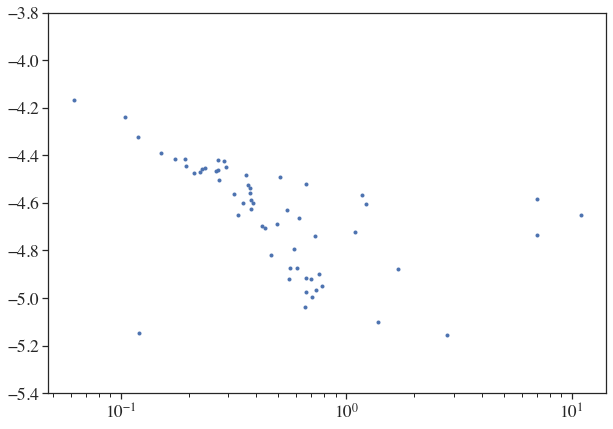

In [248]:
idx = dhk.Evol=='MS'
plt.figure(figsize=(10,7))
#plt.xlim(np.exp(-1.75), np.exp(0.15))
#plt.xlim(10**-1.75, 10**0.15)
plt.xscale("log")
plt.ylim(-5.4, -3.8)
#plt.xlim(-1.75, 0.05)
plt.plot(dhk.Ro[idx], dhk['logR\'HK'][idx], '.')

In [197]:
roR = np.logspace(np.log10(0.3), np.log10(2), 100)
roX = np.logspace(-2.5, 0, 100)
roC = np.logspace(-1.75, 0, 100)

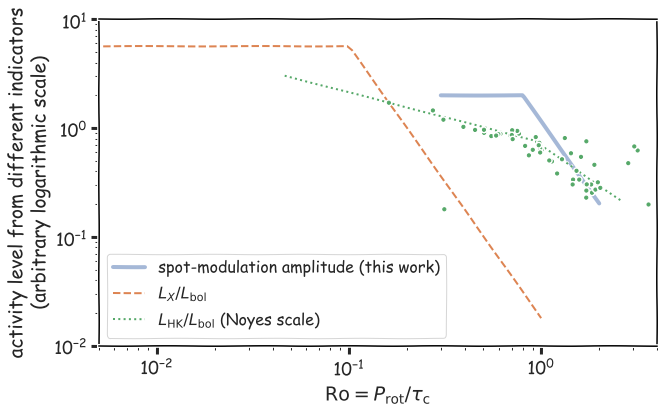

In [264]:
rc('text', usetex=False)
ronorm = np.array([0.2])
with plt.xkcd(scale=0.2):
    plt.figure(figsize=(10,6))
    plt.ylabel("activity level from different indicators\n(arbitrary logarithmic scale)")
    plt.xlabel(r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-2/2, 4)
    plt.ylim(1e-2, 10)
    plt.plot(roR, rper_ro(roR)/rper_ro(ronorm)*2, lw=4, alpha=0.5, label='spot-modulation amplitude (this work)')
    plt.plot(roX, rper_ro(roX, ro_th=0.1)/rper_ro(ronorm, ro_th=0.1), label='$L_X/L_\mathrm{bol}$', ls='dashed')
    #plt.plot(roC, Rhk_ro_hm08(roC)*1e4)
    #plt.plot(roC, Rhk_ro(roC)/Rhk_ro(ronorm), label='$L_\mathrm{HK}/L_\mathrm{bol}$', ls='dotted')
    plt.plot(roC*2.6, Rhk_ro(roC)/Rhk_ro(ronorm), label='$L_\mathrm{HK}/L_\mathrm{bol}$ (Noyes scale)', ls='dotted')
    plt.plot(dhk.Ro[idx]*2.6, 10**(dhk['logR\'HK'][idx]+4.4), '.', color='C2')
    plt.legend(loc='lower left', fontsize=16)
    plt.savefig("comparison2.png", dpi=200, bbox_inches="tight")